ДЗ1 
Реализовать mel-спектрограмму с использованием numpy и библиотеки чтения аудиофайла(например, soundfile)
Визуализировать можно с помощью matplotlib

In [1]:
!pip install numpy soundfile matplotlib 
!pip install librosa


In [2]:
import sys
print(sys.executable)
print(sys.version)


/Users/r.gulyamov/VkEducation/speech_technology_mipt/.venv/bin/python
3.10.19 (main, Oct  9 2025, 15:25:03) [Clang 17.0.0 (clang-1700.0.13.3)]


In [3]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa


In [4]:
def hz_to_mel(f_hz):
    f_hz = np.asarray(f_hz, dtype=float)
    return 2595.0 * np.log10(1.0 + f_hz / 700.0)


def mel_to_hz(m):
    m = np.asarray(m, dtype=float)
    return 700.0 * (10.0 ** (m / 2595.0) - 1.0)


def create_mel_filterbank(
    sr: int,
    n_fft: int,
    n_mels: int = 80,
    fmin: float = 0.0,
    fmax: float | None = None,
    use_slaney_norm: bool = True,
):
    if fmax is None:
        fmax = sr / 2.0

    m_min = hz_to_mel(fmin)
    m_max = hz_to_mel(fmax)
    m_points = np.linspace(m_min, m_max, n_mels + 2)
    f_points = mel_to_hz(m_points)

    fft_freqs = np.linspace(0, sr / 2.0, n_fft // 2 + 1)
    bin_indices = np.searchsorted(fft_freqs, f_points).astype(int)
    bin_indices = np.clip(bin_indices, 0, n_fft // 2)

    H = np.zeros((n_mels, n_fft // 2 + 1), dtype=float)

    for i in range(1, n_mels + 1):
        left = bin_indices[i - 1]
        center = bin_indices[i]
        right = bin_indices[i + 1]

        if center == left:
            center = left + 1
        if right == center:
            right = center + 1

        up = np.linspace(0.0, 1.0, center - left + 1, endpoint=True)
        H[i - 1, left:center + 1] += up

        down = np.linspace(1.0, 0.0, right - center + 1, endpoint=True)[1:]
        H[i - 1, center + 1:right + 1] += down

    if use_slaney_norm:
        enorm = 2.0 / (f_points[2:n_mels + 2] - f_points[:n_mels])
        H *= enorm[:, np.newaxis]

    return H


In [5]:
def mel_spectrogram(
    x: np.ndarray,
    sr: int,
    win_length_ms: float = 25.0,
    hop_length_ms: float = 10.0,
    n_fft: int = 1024,
    n_mels: int = 80,
    fmin: float = 0.0,
    fmax: float | None = None,
    pre_emphasis: float | None = None,  # для сравнения с librosa ставим None
    eps: float = 1e-10,
):
    x = np.asarray(x, dtype=np.float64)

    if x.ndim > 1:
        x = x.mean(axis=1)

    if pre_emphasis is not None and pre_emphasis != 0.0:
        y = np.empty_like(x)
        y[0] = x[0]
        y[1:] = x[1:] - pre_emphasis * x[:-1]
    else:
        y = x

    win_length = int(round(sr * win_length_ms / 1000.0))
    hop_length = int(round(sr * hop_length_ms / 1000.0))

    window = np.hanning(win_length)

    n_samples = len(y)
    if n_samples < win_length:
        pad_width = win_length - n_samples
    else:
        rest = (n_samples - win_length) % hop_length
        pad_width = 0 if rest == 0 else hop_length - rest

    if pad_width > 0:
        y = np.pad(y, (0, pad_width), mode="constant")
        n_samples = len(y)

    n_frames = 1 + (n_samples - win_length) // hop_length

    n_freqs = n_fft // 2 + 1
    P = np.empty((n_freqs, n_frames), dtype=np.float64)

    for i in range(n_frames):
        start = i * hop_length
        frame = y[start:start + win_length]
        frame_win = frame * window
        spectrum = np.fft.rfft(frame_win, n=n_fft)
        power = np.abs(spectrum) ** 2
        P[:, i] = power

    H = create_mel_filterbank(
        sr=sr,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax if fmax is not None else sr / 2.0,
        use_slaney_norm=True,
    )

    S_mel = H @ P
    S_log = np.log(S_mel + eps)

    return S_log


In [6]:
audio_path = "acoustic-guitar.wav"

x, sr = sf.read(audio_path)
print(f"Файл: {audio_path}, sr = {sr}, shape = {x.shape}")

mel = mel_spectrogram(
    x,
    sr,
    win_length_ms=25.0,
    hop_length_ms=10.0,
    n_fft=2048,
    n_mels=80,
    fmin=20.0,
    fmax=min(8000, sr / 2),
    pre_emphasis=0.97,
)

mel.shape


Файл: acoustic-guitar.wav, sr = 44100, shape = (466560, 2)


/var/folders/x5/7cx1mbgj1yl8g7b7jkv6w4080000gp/T/ipykernel_82017/3339997675.py:63: RuntimeWarning: divide by zero encountered in matmul
  S_mel = H @ P
/var/folders/x5/7cx1mbgj1yl8g7b7jkv6w4080000gp/T/ipykernel_82017/3339997675.py:63: RuntimeWarning: overflow encountered in matmul
  S_mel = H @ P
/var/folders/x5/7cx1mbgj1yl8g7b7jkv6w4080000gp/T/ipykernel_82017/3339997675.py:63: RuntimeWarning: invalid value encountered in matmul
  S_mel = H @ P


(80, 1057)

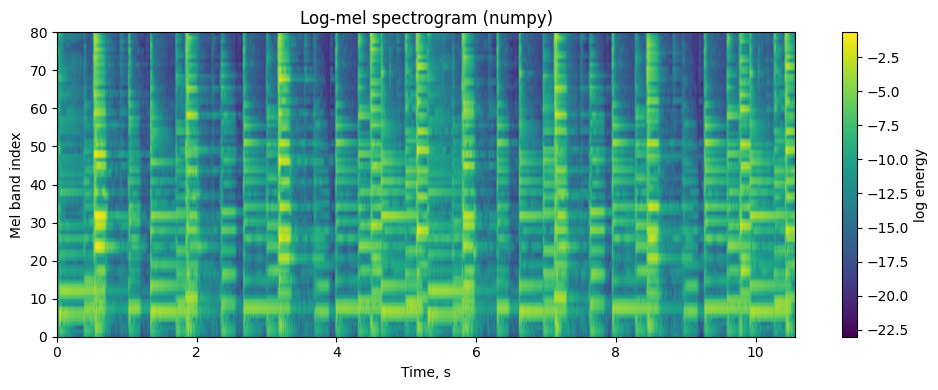

In [7]:
n_mels, n_frames = mel.shape
hop_length = int(round(sr * 10.0 / 1000.0))
duration_sec = n_frames * hop_length / sr

plt.figure(figsize=(10, 4))
plt.imshow(
    mel,
    origin="lower",
    aspect="auto",
    extent=[0, duration_sec, 0, n_mels],
)
plt.xlabel("Time, s")
plt.ylabel("Mel band index")
plt.title("Log-mel spectrogram (numpy)")
plt.colorbar(label="log energy")
plt.tight_layout()
plt.show()


In [8]:
x, sr = sf.read(audio_path)
if x.ndim > 1:
    x_mono = x.mean(axis=1)
else:
    x_mono = x

print(f"Файл: {audio_path}, sr = {sr}, shape = {x.shape}, mono shape = {x_mono.shape}")

win_length_ms = 25.0
hop_length_ms = 10.0
n_fft = 2048
n_mels = 80
fmin = 0.0
fmax = min(8000, sr / 2)

hop_length = int(round(sr * hop_length_ms / 1000.0))
win_length = int(round(sr * win_length_ms / 1000.0))

print("win_length =", win_length, "samples")
print("hop_length =", hop_length, "samples")


Файл: acoustic-guitar.wav, sr = 44100, shape = (466560, 2), mono shape = (466560,)
win_length = 1102 samples
hop_length = 441 samples


In [9]:
# НАШ log-mel
mel_ours = mel_spectrogram(
    x_mono,
    sr,
    win_length_ms=win_length_ms,
    hop_length_ms=hop_length_ms,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    pre_emphasis=None,  # для сравнения выключаем
)

print("Наш mel shape:", mel_ours.shape)


Наш mel shape: (80, 1057)


/var/folders/x5/7cx1mbgj1yl8g7b7jkv6w4080000gp/T/ipykernel_82017/3339997675.py:63: RuntimeWarning: divide by zero encountered in matmul
  S_mel = H @ P
/var/folders/x5/7cx1mbgj1yl8g7b7jkv6w4080000gp/T/ipykernel_82017/3339997675.py:63: RuntimeWarning: overflow encountered in matmul
  S_mel = H @ P
/var/folders/x5/7cx1mbgj1yl8g7b7jkv6w4080000gp/T/ipykernel_82017/3339997675.py:63: RuntimeWarning: invalid value encountered in matmul
  S_mel = H @ P


In [10]:
# librosa log-mel в тех же параметрах
mel_librosa_power = librosa.feature.melspectrogram(
    y=x_mono,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window="hann",
    center=False,
    power=2.0,
    n_mels=n_mels,
    fmin=fmin,
    fmax=fmax,
    htk=False,
    norm="slaney",
)

log_mel_librosa = np.log(mel_librosa_power + 1e-10)

print("Librosa mel shape:", log_mel_librosa.shape)


Librosa mel shape: (80, 1054)


In [11]:
# Выравниваем и считаем MAE
min_frames = min(mel_ours.shape[1], log_mel_librosa.shape[1])

A = mel_ours[:, :min_frames]
B = log_mel_librosa[:, :min_frames]

mae = np.mean(np.abs(A - B))
print("Средняя |разница| (MAE):", mae)


Средняя |разница| (MAE): 2.0127885102900867


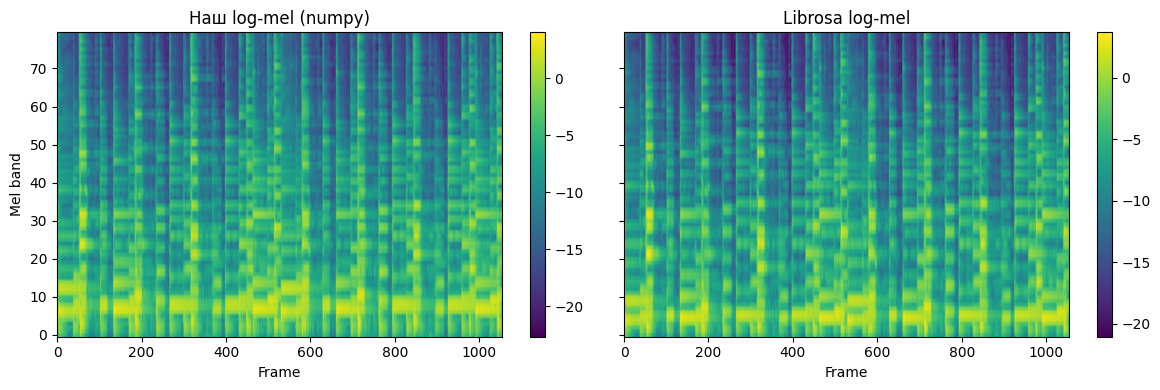

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

img0 = axes[0].imshow(A, origin="lower", aspect="auto")
axes[0].set_title("Наш log-mel (numpy)")
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Mel band")
fig.colorbar(img0, ax=axes[0])

img1 = axes[1].imshow(B, origin="lower", aspect="auto")
axes[1].set_title("Librosa log-mel")
axes[1].set_xlabel("Frame")
fig.colorbar(img1, ax=axes[1])

plt.tight_layout()
plt.show()
